In [1]:
#basic
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#torch
import torch; print('\nPyTorch version in use:', torch.__version__, '\ncuda avail: ', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

#torchvision
import torchvision
from torchvision import transforms, datasets

from copy import deepcopy
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import shutil
import time
from scipy.io import loadmat

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)


PyTorch version in use: 2.4.1+cu118 
cuda avail:  True


C:\Users\ricig\AppData\Local\Temp\ipykernel_17908\3991163402.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Device: cuda


In [2]:
#check data structure
# Load the .mat file
filename = './ARMA_AR20_MA20/ARMA_AR20_MA20/Param_valARMA_AR20_MA20.mat'
data = loadmat(filename)

# List all variables
print("Variables in the file:")
print(data.keys())

# Inspect each variable
for var_name in data:
    if var_name.startswith("__"):  # Skip meta variables
        continue
    print(f"\nVariable {var_name}:")
    print(f" Type: {type(data[var_name])}")
    print(f" Shape: {data[var_name].shape}")
    print(f" Data: {data[var_name]}")


Variables in the file:
dict_keys(['__header__', '__version__', '__globals__', 'AR', 'MA', 'Var'])

Variable AR:
 Type: <class 'numpy.ndarray'>
 Shape: (21, 1881)
 Data: [[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [-3.90101073 -5.20006363 -4.41089547 ... -3.92871812 -3.86426777
  -4.04274686]
 [ 6.79722885 13.77296884  9.23240689 ...  8.63336227  7.65312086
   8.91681327]
 ...
 [-1.39155661  4.42090272  2.75613733 ...  3.84814143  2.98449901
   3.73387747]
 [ 0.8272768  -1.22529565 -0.80322045 ... -1.24193652 -0.9715769
  -1.20251002]
 [-0.22449766  0.17250258  0.11068609 ...  0.20939519  0.15717497
   0.20198328]]

Variable MA:
 Type: <class 'numpy.ndarray'>
 Shape: (21, 1881)
 Data: [[ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [-7.57578514e-02 -1.42508247e+00 -6.59624553e-01 ... -3.31969416e-01
  -2.61137979e-01 -4.46133528e-01]
 [-1.44501547e+00  5.88981640e-01 -9.87066148e-01 ...  5.15645622e-

In [3]:
# Initialize a list to store results for each file
all_files_data = []

# Iterate through files named as numbers 1.mat to 9.mat
for file_number in range(1, 10):  # 1 to 9 inclusive
    filename = f'./ARMA_AR20_MA20/ARMA_AR20_MA20/Param_anARMA_AR20_MA20_{file_number}.mat'  # Construct the file name
    
    # Load the .mat file
    data = loadmat(filename)
    
    # Extract AR and MA from the loaded data
    AR = data['AR'][1:, :]  # Exclude the first row of AR
    MA = data['MA'][1:, :]  # Exclude the first row of MA
    
    # Number of columns (assuming consistent structure across files)
    n_columns = AR.shape[1]
    
    # Initialize a list to hold the concatenated arrays for this file
    concatenated_arrays = []
    
    # Loop through each column and concatenate all 10 rows of AR and MA
    for i in range(n_columns):
        ar_elements = AR[:, i]
        ma_elements = MA[:, i]
        concatenated = np.concatenate((ar_elements, ma_elements))  # Concatenate to a 1x21 array
        concatenated_arrays.append(concatenated)
    
    # Convert the list to a NumPy array (if needed)
    concatenated_arrays = np.array(concatenated_arrays)  # Shape will be (n_columns, 21)
    
    # Append the result for this file to the main list
    all_files_data.append(concatenated_arrays)

# Print a summary of the results
for idx, file_data in enumerate(all_files_data, start=1):
    print(f"File {idx}: Shape of concatenated array: {file_data.shape}")
    print(f"Example from file {idx}: {file_data[0]}")


File 1: Shape of concatenated array: (1881, 40)
Example from file 1: [-4.80586808e+00  1.22758134e+01 -2.15218623e+01  2.90066053e+01
 -3.23088631e+01  3.19083484e+01 -3.00238843e+01  2.77785997e+01
 -2.41309215e+01  1.78648791e+01 -9.76745976e+00  2.39660698e+00
  1.81335379e+00 -2.28746429e+00  5.95585636e-01  1.08863846e+00
 -1.59947429e+00  1.19120590e+00 -5.20232329e-01  1.17735572e-01
 -1.14660251e+00  5.34654448e-01  1.75402560e-01  1.08623910e-01
 -3.34109551e-01  2.95419096e-01 -4.37252294e-02 -4.47296790e-01
  6.15822391e-01 -2.12287798e-01 -7.09746021e-03 -2.57080743e-03
 -2.72811363e-01  2.30568864e-01  2.31359540e-01 -2.18140459e-01
 -2.26261151e-02  6.22596732e-02  1.90817647e-01  8.70290453e-02]
File 2: Shape of concatenated array: (2038, 40)
Example from file 2: [-5.48111614e+00  1.39109901e+01 -2.17819428e+01  2.43830242e+01
 -2.30505897e+01  2.21989985e+01 -2.25465333e+01  2.18483949e+01
 -1.96873806e+01  1.74475594e+01 -1.55581689e+01  1.35646654e+01
 -1.15200120e+01

In [4]:
# Initialize a list to hold the concatenated arrays for this file
concatenated_arrays = []

# List of filenames
filenames = ['Param_testARMA_AR20_MA20.mat', 'Param_trainARMA_AR20_MA20.mat', 'Param_valARMA_AR20_MA20.mat']

# Iterate through each file in the filenames list
for filename in filenames:
    filepath = f'./ARMA_AR20_MA20/ARMA_AR20_MA20/{filename}'  # Construct the file path
    
    # Load the .mat file
    data = loadmat(filepath)
    
    # Extract AR and MA from the loaded data
    AR = data['AR'][1:, :]  # Exclude the first row of AR
    MA = data['MA'][1:, :]  # Exclude the first row of MA
    
    # Number of columns (assuming consistent structure across files)
    n_columns = AR.shape[1]
    
    # Loop through each column and concatenate all 10 rows of AR and MA
    for i in range(n_columns):
        ar_elements = AR[:, i]
        ma_elements = MA[:, i]
        concatenated = np.concatenate((ar_elements, ma_elements))  # Concatenate to a 1x21 array
        concatenated_arrays.append(concatenated)
    
# Convert the list to a NumPy array (if needed)
concatenated_arrays = np.array(concatenated_arrays)  # Shape will be (n_columns, 21)

# Print a summary of the results
print(f"Shape of concatenated array: {concatenated_arrays.shape}")
print(f"Example: {concatenated_arrays[0]}")


Shape of concatenated array: (17140, 40)
Example: [ -4.24996107   8.83124048 -12.1041858   12.88391068 -12.12542702
  10.84746948  -9.02268439   6.64296631  -4.9272183    5.17921079
  -6.97726565   9.08531467 -10.99457855  12.2527743  -11.94296585
   9.75790012  -6.35677025   3.064161    -0.95430824   0.1413751
  -0.68656012  -0.77203651   0.36533082   1.00038499  -0.15972495
  -0.94666567   0.23837929   0.74032276  -0.65493046  -0.19679464
   0.3255874    0.81341077  -0.6870611   -0.86962736   0.6498781
   0.54698225  -0.09518076  -0.34691736   0.02156371   0.14242517]


In [5]:
def save_arrays_labeled(reshaped_array, output_directory, label):
    # Loop through each row in the reshaped array
    for i in range(reshaped_array.shape[0]):
        # Extract the current 1x512 array
        single_array = reshaped_array[i]
        
        # Define the file name for the output
        file_name = f'{output_directory}/array_{i}_{label}.npy'
        
        # Save the array as a .npy file
        np.save(file_name, single_array)


In [6]:
output_directory = './ARMA_AR20_MA20_labeled_data'

# Remove the directory if it exists and create a new one
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

os.makedirs(output_directory)

# Call the function to save the arrays
for i in range(len(all_files_data)):  # Iterate through indices 0 to 8
    save_arrays_labeled(all_files_data[i], output_directory, i + 1)  # File numbering starts from 1
save_arrays_labeled(concatenated_arrays, output_directory, 0)


# If provided dataset, start from here

In [2]:
def load_dataset_and_labels(directory):
    # Initialize lists to hold the data and labels
    data = []
    labels = []

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.npy'):
            # Load the .npy file
            array = np.load(os.path.join(directory, filename))
            
            # Extract the label from the filename
            label = int(filename.split('_')[2].split('.')[0])
            
            # Append the array and label to the respective lists
            data.append(array)
            labels.append(label)
    
    # Convert lists to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

output_directory = './ARMA_AR20_MA20_labeled_data'
# Call the function to load the dataset and labels
data, labels = load_dataset_and_labels(output_directory)

data = (data - data.mean()) / data.std()

# Print shapes to verify
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print(labels)


Data shape: (35169, 40)
Labels shape: (35169,)
[0 1 2 ... 7 8 9]


In [3]:
# Separate the data and labels into majority (label 0) and minority classes
majority_class_data = data[labels == 0]
majority_class_labels = labels[labels == 0]

minority_class_data = data[labels != 0]
minority_class_labels = labels[labels != 0]

# Combine majority data and labels into a single array for undersampling
combined_majority_data = majority_class_data.reshape(-1, majority_class_data.shape[-1])
combined_majority_labels = majority_class_labels

# Set the desired ratio of the majority class to the minority classes
undersample_ratio = len(minority_class_labels) // len(np.unique(minority_class_labels))

# Randomly select indices for undersampling the majority class
undersample_indices = np.random.choice(len(majority_class_data), size=undersample_ratio, replace=False)
majority_class_data_undersampled = majority_class_data[undersample_indices]
majority_class_labels_undersampled = majority_class_labels[undersample_indices]

# Combine the undersampled majority class with the minority classes
data_resampled = np.vstack((majority_class_data_undersampled, minority_class_data))
labels_resampled = np.hstack((majority_class_labels_undersampled, minority_class_labels))

# Print shapes to verify
print("Data shape:", data_resampled.shape)
print("Labels shape:", labels_resampled.shape)

# Convert resampled data to tensors
data_tensor_resampled = torch.tensor(data_resampled, dtype=torch.float32)
labels_tensor_resampled = torch.tensor(labels_resampled, dtype=torch.long)

Data shape: (20032, 40)
Labels shape: (20032,)


In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

In [5]:
custom_dataset = CustomDataset(data_tensor_resampled, labels_tensor_resampled)

In [6]:
data = []
labels = []
data_resampled = []
labels_resampled = []

In [7]:
batch_size = 128

def get_data_loaders(dataset, train_batch_size=batch_size, val_batch_size=batch_size, test_batch_size=batch_size, train_ratio=0.7, val_ratio=0.15):
    # Ensure the ratios sum to 1
    test_ratio = 1 - train_ratio - val_ratio
    if test_ratio <= 0:
        raise ValueError("The sum of train_ratio and val_ratio must be less than 1.")
    
    # Determine sizes for training, validation, and test sets
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    # Create DataLoaders for the splits
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
    
    print(f"Dataset split sizes - Train: {train_size}, Validation: {val_size}, Test: {test_size}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    
    return train_loader, val_loader, test_loader

# Example usage
train_loader, val_loader, test_loader = get_data_loaders(custom_dataset, batch_size, batch_size, batch_size)

# Check one batch from the train loader
for batch_idx, (samples, labels) in enumerate(train_loader):
    print(f"Train Batch {batch_idx}:")
    print(f"Samples: {samples.shape}")
    print(f"Labels: {labels.shape}")
    break  # Just to see the first batch


Dataset split sizes - Train: 14022, Validation: 3004, Test: 3006
Number of training batches: 110
Number of validation batches: 24
Number of test batches: 24
Train Batch 0:
Samples: torch.Size([128, 40])
Labels: torch.Size([128])


In [29]:
class CNN(nn.Module):
    def __init__(self, n_classes=10):
        super(CNN, self).__init__()
        
        # First convolution block: input 1x40 -> output 16x40
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)  # BatchNorm after conv
        
        # Second convolution block: input 16x40 -> output 32x40
        self.conv2 = nn.Conv1d(16, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(16)

        # Max Pooling: input 32x40 -> output 32x20
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # Third convolution block: input 32x20 -> output 32x20
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)    
        self.bn3 = nn.BatchNorm1d(32)

        # Fourth convolution block: input 32x20 -> output 64x20
        self.conv4 = nn.Conv1d(32, 32, kernel_size=3, padding=1) 
        self.bn4 = nn.BatchNorm1d(32)

        # Max Pooling: input 64x20 -> output 64x10
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)

        # Fifth convolution block: input 64x10 -> output 128x10
        self.conv5 = nn.Conv1d(32, 64, kernel_size=3, padding=1)    
        self.bn5 = nn.BatchNorm1d(64)

        # Sixth convolution block: input 128x10 -> output 128x10
        self.conv6 = nn.Conv1d(64, 64, kernel_size=3, padding=1) 
        self.bn6 = nn.BatchNorm1d(64)

        # Max Pooling: input 128x10 -> output 128x5
        self.maxpool3 = nn.MaxPool1d(kernel_size=2)

        # Global Average Pooling: input 256x31 -> output 256x1
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer: input 256 -> output n_classes
        self.fc = nn.Linear(64, n_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Convert to [N, 1, L] for Conv1d

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn3(self.conv3(x)))  
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)

        x = F.relu(self.bn5(self.conv5(x)))  
        x = F.relu(self.bn6(self.conv6(x))) 
        x = self.maxpool3(x)

        x = self.global_avg_pool(x)  # Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc(x)
        x = F.softmax(x, dim=1)
        
        return x

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model and move it to the device
net = CNN().to(device)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedCNN(nn.Module):
    def __init__(self, n_classes=10):
        super(EnhancedCNN, self).__init__()
        # Increase filters and use larger kernels
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, padding=3)  # from 1 to 64 channels
        self.bn1 = nn.BatchNorm1d(64)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)  # 40 -> 20

        self.conv3 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)  # 20 -> 10

        # Fully connected layers for classification
        self.fc1 = nn.Linear(128 * 10, 256)
        self.dropout = nn.Dropout(0.3)  # Reduced dropout rate
        self.fc2 = nn.Linear(256, n_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Shape: [N, 1, 40]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No softmax here; use CrossEntropyLoss later.
        return x

# Define the device and instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = EnhancedCNN(n_classes=10).to(device)


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedARMA_Net(nn.Module):
    def __init__(self, input_length=40, num_classes=10):
        super(EnhancedARMA_Net, self).__init__()
        # First convolution layer: increase filter count and use larger kernel
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduces length from 40 -> 20
        
        # Second convolution layer: maintain or increase filters
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)  # 20 -> 10
        
        # Optional Third convolution layer for extra capacity
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        # No pooling here to preserve feature resolution
        
        # Flatten and Fully connected layers
        self.flatten = nn.Flatten()
        # Calculate flattened size: after two poolings, length=40//(2*2)=10; channels=64
        self.fc1 = nn.Linear(64 * 10, 128)
        self.dropout = nn.Dropout(0.3)  # Slight dropout to regularize
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Convert to [Batch, 1, Length]
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.maxpool2(x)
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # Return raw logits; apply softmax during inference if needed.
        return x

# Instantiate the model:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = EnhancedARMA_Net(input_length=40, num_classes=10).to(device)
print(net)


EnhancedARMA_Net(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=640, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [47]:
class ResNet50FineTuned(nn.Module):
    def __init__(self, n_classes=10):
        super(ResNet50FineTuned, self).__init__()
        # Load pretrained ResNet50
        self.resnet50 = models.resnet50(pretrained=True)

        # Modify the input layer to accept 1 channel instead of 3
        self.resnet50.conv1 = nn.Conv2d(
            in_channels=1,  # Single channel input
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False
        )
        
        # Freeze all layers except the final FC layer
        #for param in self.resnet50.parameters():
            #param.requires_grad = False
        
        # Replace the final fully connected layer
        self.resnet50.fc = nn.Linear(in_features=2048, out_features=n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        
        # Pass through the modified ResNet50
        x = self.resnet50(x)
        
        # Apply softmax for output probabilities
        return F.softmax(x, dim=1)

net = ResNet50FineTuned().to(device)
print(net)

ResNet50FineTuned(
  (resnet50): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [39]:
# input_size = (batch_n, img_ch,img_width, img_height)
input_size = (batch_size, 40)
input = torch.randn(input_size).to(device)

print("Before passing to the model:", input.shape)

# Create the model and pass the input
output = net(input)

print('Output shape:', output.shape)
print('Network Topology:\n',net)

Before passing to the model: torch.Size([128, 40])
Output shape: torch.Size([128, 10])
Network Topology:
 EnhancedARMA_Net(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=640, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linea

In [40]:
def network_size_and_mac(net, input_size, verbose=False):
    # Calculate the number of parameters
    summary_info = summary(net, input_size=input_size, verbose=verbose)
    params = summary_info.total_params

    # Calculate MACs using thop
    from thop import profile
    macs, _ = profile(net, inputs=(torch.randn(input_size).to(next(net.parameters()).device),))

    print("Network's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))

network_size_and_mac(net, input_size)



[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Network's 	n°params: 108.810k 	MAC: 61.768M



In [41]:
def calculate_accuracy(best_guesses, targets):
    # Calculate the number of correct predictions
    num_correct = (best_guesses == targets).sum().item()
    
    # Calculate the total number of predictions
    total_guesses = targets.size(0)
    
    # Calculate the accuracy as a percentage
    correct_percentage = num_correct / total_guesses
    
    return correct_percentage

In [42]:
# Define loss function
loss_function = nn.CrossEntropyLoss()


In [43]:
def validate(net, val_loader, loss_function, accuracy_score):
    val_losses = []
    val_accuracy = []
    
    # Set net to evaluation mode
    net.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass: get predictions from the network
            outputs = net(inputs)

            # Calculate loss
            loss = loss_function(outputs, labels)
            val_losses.append(loss.item())  # Append current loss to a buffer variable for plotting learning curve

            # Calculate validation accuracy
            predicted_classes = torch.max(outputs, 1)[1]  # Get class from network's prediction
            val_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu())) 
            # val_accuracy.append(calculate_metric(accuracy_score, labels.cpu(), predicted_classes.cpu())) # This is the same accuracy calculated with scikit-learn
            
    average_val_loss = sum(val_losses) / (batch_idx + 1)
    return val_accuracy, average_val_loss


In [44]:
val_accuracy, average_val_loss = validate(net, test_loader, loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(val_accuracy)/len(val_accuracy)))

Accuracy: 0.10


In [45]:
epochs = 50
batch_size = 128

# Move net to gpu:
net.to(device)

# Build Dataloaders
train_loader, val_loader, test_loader = get_data_loaders(custom_dataset, batch_size, batch_size, batch_size)

# Create lists to store training history
train_loss_history = []
train_accuracy_history = []
# Create lists to store validation history
val_loss_history = []
val_accuracy_history = []

def training(net, train_loader, val_loader, loss_function, epochs, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history):    
    # Define optimizer
    optimizer = optim.Adam(net.parameters())

    # Count total batches
    tot_train_batches = len(train_loader)
    tot_val_batches = len(val_loader)

    start_ts = time.time()     

    # ----------------- TRAINING  -------------------- #
    # Loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        total_epoch_loss = 0
        train_accuracy = []

        net.train() # Set model to training mode
        # Loop for every batch of images in the dataset
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # Compute prediction (forward pass)
            outputs = net(inputs)
            # Compute prediction error with the loss function
            loss = loss_function(outputs, labels)
            # Gradients to zero for every batch of data
            optimizer.zero_grad()
            # Backpropagation
            loss.backward()
            # Optimizer step
            optimizer.step()
            
            # Getting training quality data
            current_loss = loss.item()

            # Compute average loss
            total_epoch_loss += current_loss
            average_train_loss = total_epoch_loss / (batch_idx + 1)
            
            # Calculate training accuracy
            predicted_classes = torch.max(outputs, 1)[1] # Get class from network's prediction
            train_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu())) 

            average_train_accuracy = sum(train_accuracy) / (batch_idx + 1)
            

        # ----------------- VALIDATION  ----------------- #
        val_accuracy, val_loss = validate(net, val_loader, loss_function, calculate_accuracy)

        # Compute mean accuracy
        average_train_accuracy = sum(train_accuracy) / tot_train_batches
        average_val_accuracy = sum(val_accuracy) / tot_val_batches

        # Print training/validation Accuracy and Loss
        print('Epoch %d/%d' % (epoch + 1, epochs), 'Training loss:  %.4f' % (average_train_loss), 'Accuracy: %.4f' % (average_train_accuracy))
        print('Validation Loss: %.4f' % (val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

        # Append current average training loss to a buffer variable, for plotting learning curve later
        train_loss_history.append(float(average_train_loss))
        val_loss_history.append(float(val_loss))
        train_accuracy_history.append(float(average_train_accuracy))
        val_accuracy_history.append(float(average_val_accuracy))

    print('Training time: %.1f seconds' % (time.time() - start_ts)) 

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


Dataset split sizes - Train: 14022, Validation: 3004, Test: 3006
Number of training batches: 110
Number of validation batches: 24
Number of test batches: 24


In [46]:
epochs = 100

(train_loss_history,
train_accuracy_history, 
val_loss_history, 
val_accuracy_history) = training(net, train_loader, val_loader, loss_function, epochs, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history)

Epoch 1/100 Training loss:  2.3067 Accuracy: 0.1020
Validation Loss: 2.3017 Accuracy: 0.1195
Epoch 2/100 Training loss:  2.3003 Accuracy: 0.1125
Validation Loss: 2.3010 Accuracy: 0.1153
Epoch 3/100 Training loss:  2.2809 Accuracy: 0.1300
Validation Loss: 2.2559 Accuracy: 0.1408
Epoch 4/100 Training loss:  2.2266 Accuracy: 0.1570
Validation Loss: 2.1862 Accuracy: 0.1633
Epoch 5/100 Training loss:  2.1528 Accuracy: 0.1964
Validation Loss: 2.3017 Accuracy: 0.1223
Epoch 6/100 Training loss:  2.0586 Accuracy: 0.2323
Validation Loss: 2.0157 Accuracy: 0.2159
Epoch 7/100 Training loss:  1.9740 Accuracy: 0.2575
Validation Loss: 2.5539 Accuracy: 0.1306
Epoch 8/100 Training loss:  1.9099 Accuracy: 0.2753
Validation Loss: 1.8444 Accuracy: 0.2877
Epoch 9/100 Training loss:  1.8807 Accuracy: 0.2838
Validation Loss: 2.0523 Accuracy: 0.1970
Epoch 10/100 Training loss:  1.8567 Accuracy: 0.2918
Validation Loss: 2.2843 Accuracy: 0.1752
Epoch 11/100 Training loss:  1.8071 Accuracy: 0.3067
Validation Loss:

Epoch 89/100 Training loss:  1.4132 Accuracy: 0.4220
Validation Loss: 1.7273 Accuracy: 0.3447
Epoch 90/100 Training loss:  1.4110 Accuracy: 0.4280
Validation Loss: 1.8218 Accuracy: 0.3166
Epoch 91/100 Training loss:  1.4093 Accuracy: 0.4291
Validation Loss: 2.6630 Accuracy: 0.2131
Epoch 92/100 Training loss:  1.4043 Accuracy: 0.4268
Validation Loss: 1.6776 Accuracy: 0.3669
Epoch 93/100 Training loss:  1.3917 Accuracy: 0.4363
Validation Loss: 1.6336 Accuracy: 0.3707
Epoch 94/100 Training loss:  1.4014 Accuracy: 0.4233
Validation Loss: 1.9847 Accuracy: 0.2613
Epoch 95/100 Training loss:  1.3973 Accuracy: 0.4288
Validation Loss: 4.0278 Accuracy: 0.1570
Epoch 96/100 Training loss:  1.4038 Accuracy: 0.4233
Validation Loss: 1.6921 Accuracy: 0.3273
Epoch 97/100 Training loss:  1.4012 Accuracy: 0.4309
Validation Loss: 1.7258 Accuracy: 0.3662
Epoch 98/100 Training loss:  1.3866 Accuracy: 0.4354
Validation Loss: 2.0914 Accuracy: 0.2519
Epoch 99/100 Training loss:  1.3876 Accuracy: 0.4371
Validat

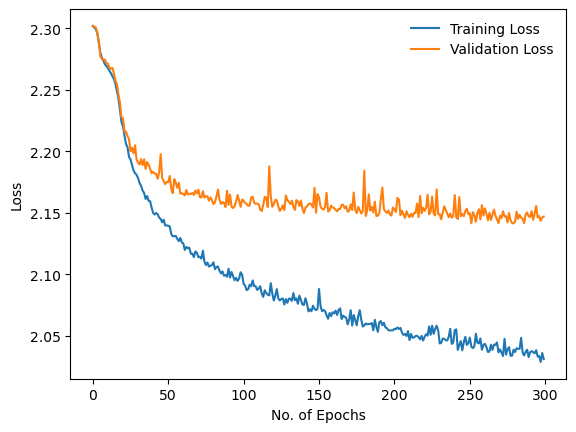

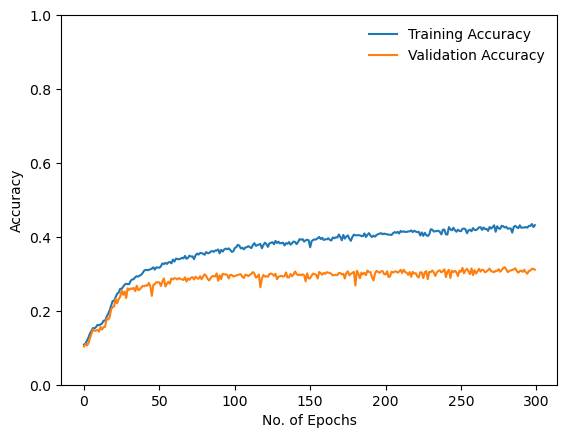

In [37]:
# Assuming train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history are already defined

# Plot training/validation loss
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

# Plot training/validation accuracy
plt.plot(train_accuracy_history, label="Training Accuracy")
plt.plot(val_accuracy_history, label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.ylim([0., 1.]) # Limit y axis between 0 and 1
plt.legend(frameon=False)
plt.show()


In [ ]:
test_accuracy, average_test_loss = validate(net, test_loader, loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(test_accuracy)/len(test_accuracy)))

In [ ]:
model_export_path = "./SI_model/"
model_name = 'SI_CNN_resnet.pth'
os.makedirs(model_export_path, exist_ok=True)

#Save Pytorch model
def save_net(net, model_path, model_name):
    # Save PyTorch model
    model_full_path = os.path.join(model_path, model_name)
    torch.save(net.state_dict(), model_full_path)
    print(f'Model saved to {model_full_path}')

# Example usage
save_net(net, model_export_path, model_name)